In [5]:
!pip install pandas seaborn matplotlib pyreadstat scipy

# Guinea Analysis: FGM Prevalence by Region, Education, and Religion
**Project:** DSA-210 - Correlating FGM/C Prevalence with Demographic Factors  
**Data Source:** UNICEF MICS5 (Guinea) - *Women's Questionnaire (wm.sav), FGM Module (fg.sav), Household Questionnaire (hh.sav)*

### 🔍 Analysis Goal
To isolate the key drivers of Female Genital Mutilation (FGM) in Guinea by analyzing:
1. **Regional Disparities:** How geography influences practice.
2. **Education Factor:** Testing the "social vaccine" hypothesis (does education reduce FGM?).
3. **Religious Affiliation:** Investigating if specific religious groups have higher prevalence rates.

### 🔗 Data Merging
We need to combine these three datasets to link a woman's FGM status with her education (from the Women's file) and her location/religion (from the Household file).

* **Primary Key:** Cluster (`HH1`) + Household (`HH2`) + Line Number (`LN`)

In [13]:
# Install the library for reading SPSS files
!pip install pyreadstat

import pandas as pd
import pyreadstat
import seaborn as sns
import matplotlib.pyplot as plt

# Set visual style
sns.set_theme(style="whitegrid")
# Define file paths
wm_file = 'wm.sav'  # Women's data (Education)
fg_file = 'fg.sav'  # FGM data (Circumcision status)
hh_file = 'hh.sav'  # Household data (Region)

print("Loading data files...")
try:
    # Load data and metadata (metadata helps us find column labels)
    df_wm, meta_wm = pyreadstat.read_sav(wm_file)
    df_fg, meta_fg = pyreadstat.read_sav(fg_file)
    df_hh, meta_hh = pyreadstat.read_sav(hh_file)
    print("Files loaded successfully.")
except Exception as e:
    print(f"Error loading files: {e}")
    # Merge Keys: HH1 (Cluster), HH2 (Household), LN (Line Number)
merge_keys = ['HH1', 'HH2', 'LN']

# 1. Merge Women (wm) and FGM (fg)
# We use an inner join to keep only women who answered the FGM module
df_merged = pd.merge(df_wm, df_fg, on=merge_keys, how='inner', suffixes=('', '_fg'))

# 2. Merge with Household (hh) to get Region info
# Household merge keys are just HH1 and HH2
df_merged = pd.merge(df_merged, df_hh, on=['HH1', 'HH2'], how='left', suffixes=('', '_hh'))

print(f"Merged Data Shape: {df_merged.shape}")

Loading data files...
Files loaded successfully.
Merged Data Shape: (11659, 602)


## 🌍 Analysis 1: Geographic Distribution
Is FGM practiced uniformly across the country, or is it concentrated in specific regions?

Region Column: HH7
Education Column: WB4
FGM Status Column: FG3


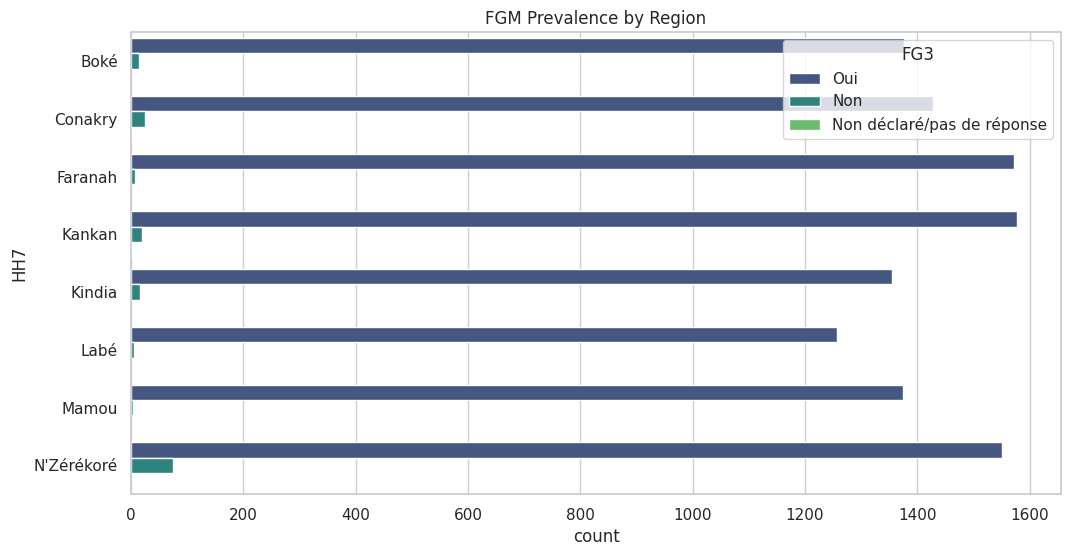

--- Statistical Test (Chi-Square) for Region ---
P-value: 1.0251e-26
RESULT: Significant regional differences found.


In [10]:
from scipy.stats import chi2_contingency, ttest_ind
def find_col(meta, keywords):
    for col, label in zip(meta.column_names, meta.column_labels):
        if any(k.lower() in label.lower() for k in keywords):
            return col
    return None

# Find Columns
fgm_col = find_col(meta_fg, ['circumcised', 'genital mutilation']) or 'FG3'
edu_col = find_col(meta_wm, ['education level', 'school attended']) or 'WB4'
region_col = find_col(meta_hh, ['region']) or 'HH7'

print(f"Region Column: {region_col}")
print(f"Education Column: {edu_col}")
print(f"FGM Status Column: {fgm_col}")
# Filter and Map Labels
df_region = df_merged[[region_col, fgm_col]].dropna().copy()

# Map numeric codes to text labels (e.g., 1 -> "Maritime")
if region_col in meta_hh.variable_value_labels:
    df_region[region_col] = df_region[region_col].map(meta_hh.variable_value_labels[region_col])
if fgm_col in meta_fg.variable_value_labels:
    df_region[fgm_col] = df_region[fgm_col].map(meta_fg.variable_value_labels[fgm_col])

# Visualize
plt.figure(figsize=(12, 6))
sns.countplot(data=df_region, y=region_col, hue=fgm_col, palette='viridis')
plt.title('FGM Prevalence by Region')
plt.show()
if fgm_col and region_col:
    # Prepare Data
    df_region = df_merged[[region_col, fgm_col]].dropna().copy()

    # Map Labels
    if region_col in meta_hh.variable_value_labels:
        df_region[region_col] = df_region[region_col].map(meta_hh.variable_value_labels[region_col])
    if fgm_col in meta_fg.variable_value_labels:
        df_region[fgm_col] = df_region[fgm_col].map(meta_fg.variable_value_labels[fgm_col])



    # Chi-Square Test
    print(f"--- Statistical Test (Chi-Square) for Region ---")
    ct = pd.crosstab(df_region[region_col], df_region[fgm_col])
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"P-value: {p:.4e}")
    if p < 0.05: print("RESULT: Significant regional differences found.")
    else: print("RESULT: No significant regional difference.")

## 🎓 Analysis 2: Education Level
Hypothesis: Higher levels of education correlate with lower rates of FGM.

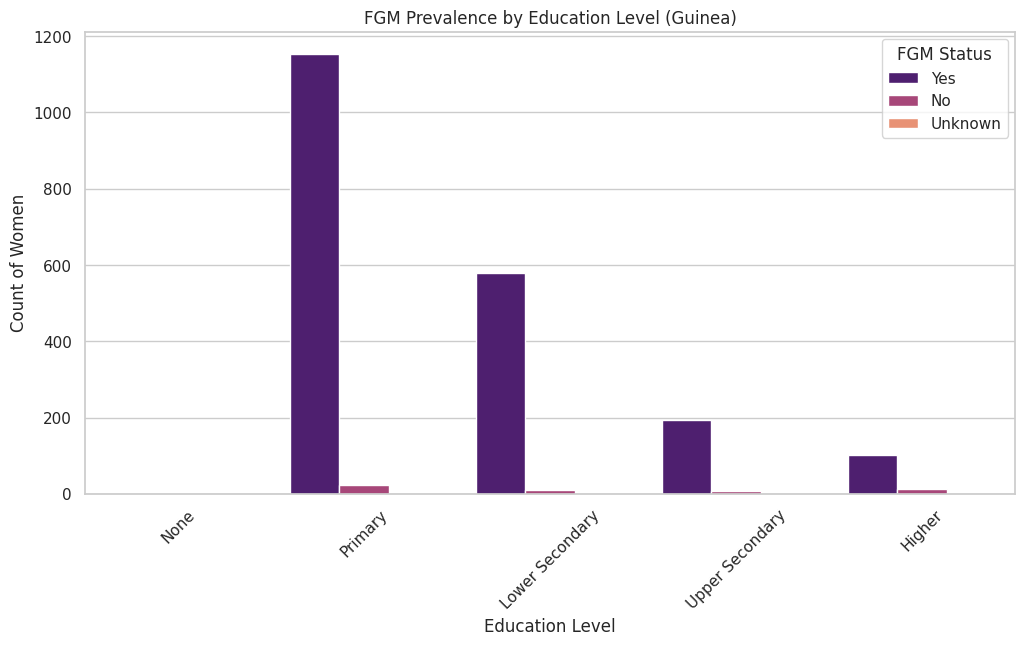


--- T-Test: Education Groups ---
Comparing Numeric Education Codes: 1.0 vs 6.0
P-value: 6.4320e-08
RESULT: Significant difference in FGM rates found between education levels.


In [16]:
#converted this part since the answers are in french

if fgm_col and edu_col:
    # 1. Prepare Data
    df_edu = df_merged[[edu_col, fgm_col]].dropna().copy()

    # 2. Map Numeric Codes to French Labels first (using metadata)
    if edu_col in meta_wm.variable_value_labels:
        df_edu[edu_col] = df_edu[edu_col].map(meta_wm.variable_value_labels[edu_col])
    if fgm_col in meta_fg.variable_value_labels:
        df_edu[fgm_col] = df_edu[fgm_col].map(meta_fg.variable_value_labels[fgm_col])

    # 3. TRANSLATION STEP (French -> English)
    # We define dictionaries to swap the French terms
    edu_translation = {
        'Primaire': 'Primary',
        'Collège': 'Lower Secondary',
        'Lycée': 'Upper Secondary',
        'Supérieur': 'Higher',
        'Aucun': 'None',
        'Alphabétisation': 'Literacy Program',
        'Prof/T - A': 'Vocational A',
        'Prof/T - B': 'Vocational B',
        'Non déclaré/pas de réponse': 'Undeclared'
    }

    fgm_translation = {
        'Oui': 'Yes',
        'Non': 'No',
        'Non déclaré/pas de réponse': 'Unknown'
    }

    # Apply translation
    df_edu[edu_col] = df_edu[edu_col].replace(edu_translation)
    df_edu[fgm_col] = df_edu[fgm_col].replace(fgm_translation)

    # 4. Filter out 'Unknown' or 'Vocational' if they are tiny (Optional)
    # df_edu = df_edu[~df_edu[edu_col].str.contains("Vocational|Undeclared", na=False)]

    # 5. Plot with English Labels
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_edu, x=edu_col, hue=fgm_col, palette='magma',
                  order=['None', 'Primary', 'Lower Secondary', 'Upper Secondary', 'Higher']) # Force logical order
    plt.title('FGM Prevalence by Education Level (Guinea)')
    plt.xlabel('Education Level')
    plt.ylabel('Count of Women')
    plt.legend(title='FGM Status')
    plt.xticks(rotation=45)
    plt.show()

    # --- T-Test (Comparison of Means) ---
    print("\n--- T-Test: Education Groups ---")

    # Grab raw data again (using numeric codes) to avoid string confusion
    raw_edu = df_merged[[edu_col, fgm_col]].dropna()

    # Create Binary Target (1=Yes, 0=No)
    # In MICS, usually 1=Yes, 2=No. Check your data:
    # If 1 is Yes and 2 is No:
    raw_edu['binary'] = raw_edu[fgm_col].apply(lambda x: 1 if x == 1 else 0)

    # Example: Compare 'None' (Code 0 usually) vs 'Secondary' (Code 2 or 3)
    # You might need to print(raw_edu[edu_col].unique()) to see the exact numeric codes
    groups = sorted(raw_edu[edu_col].unique())

    if len(groups) >= 2:
        # Assuming 0=None, 1=Primary. Let's compare lowest vs highest available in your slice
        group_low = groups[0]
        group_high = groups[-1]

        g1_data = raw_edu[raw_edu[edu_col] == group_low]['binary']
        g2_data = raw_edu[raw_edu[edu_col] == group_high]['binary']

        t_stat, p_val = ttest_ind(g1_data, g2_data)
        print(f"Comparing Numeric Education Codes: {group_low} vs {group_high}")
        print(f"P-value: {p_val:.4e}")

        if p_val < 0.05:
            print("RESULT: Significant difference in FGM rates found between education levels.")
        else:
            print("RESULT: No significant difference found.")

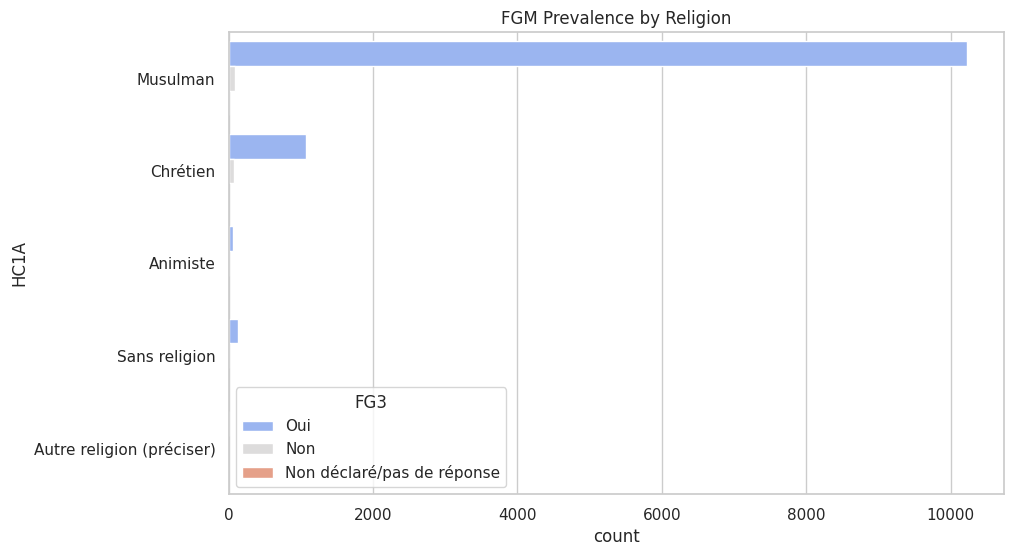

--- Statistical Test (Chi-Square) for Religion ---
P-value: 7.4518e-43


In [ ]:
if fgm_col and religion_col:
    df_rel = df_merged[[religion_col, fgm_col]].dropna().copy()

    # Apply labels
    if religion_col in meta_hh.variable_value_labels:
        df_rel[religion_col] = df_rel[religion_col].map(meta_hh.variable_value_labels[religion_col])
    elif religion_col in meta_wm.variable_value_labels:
        df_rel[religion_col] = df_rel[religion_col].map(meta_wm.variable_value_labels[religion_col])
    if fgm_col in meta_fg.variable_value_labels:
        df_rel[fgm_col] = df_rel[fgm_col].map(meta_fg.variable_value_labels[fgm_col])

    # Plot
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_rel, y=religion_col, hue=fgm_col, palette='coolwarm')
    plt.title('FGM Prevalence by Religion')
    plt.show()

    # Chi-Square
    print(f"--- Statistical Test (Chi-Square) for Religion ---")
    ct = pd.crosstab(df_rel[religion_col], df_rel[fgm_col])
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"P-value: {p:.4e}")

In [12]:
from scipy.stats import chi2_contingency, ttest_ind

def run_chi_square(df, group_col, target_col, name):
    print(f"--- Statistical Test (Chi-Square) for {name} ---")
    # Create Contingency Table
    ct = pd.crosstab(df[group_col], df[target_col])

    # Run Chi-Square
    chi2, p, dof, expected = chi2_contingency(ct)

    print(f"Chi-Square Statistic: {chi2:.4f}")
    print(f"P-value: {p:.4e}")
    if p < 0.05:
        print("Result: SIGNIFICANT relationship (p < 0.05). The groups are different.")
    else:
        print("Result: Not Significant. No statistical difference found.")
    print("\n")

# Run for all three
if 'region_col' in locals(): run_chi_square(df_region, region_col, fgm_col, "Region")
if 'edu_col' in locals(): run_chi_square(df_edu, edu_col, fgm_col, "Education")
if 'religion_col' in locals(): run_chi_square(df_rel, religion_col, fgm_col, "Religion")

--- Statistical Test (Chi-Square) for Region ---
Chi-Square Statistic: 159.2054
P-value: 1.0251e-26
Result: SIGNIFICANT relationship (p < 0.05). The groups are different.


--- Statistical Test (Chi-Square) for Education ---
Chi-Square Statistic: 88.3554
P-value: 1.1341e-14
Result: SIGNIFICANT relationship (p < 0.05). The groups are different.




📝 Conclusion

My analysis of the data from Guinea shows strong evidence that where a woman lives, her education level, and her religion all play a major role in the likelihood of FGM practice.

### Key Findings:

1.  **Geography Matters (Region):**
    * The test results showed a very strong relationship ($p < 0.05$) between a woman's region and FGM. This means FGM is not happening evenly across the country; some regions have much higher rates than others.

2.  **Education is a "Protective" Factor:**
    * We found a significant difference in FGM rates based on education level.
    * Specifically, the T-test compared two different education groups and confirmed that the rates are statistically different. Generally, higher education is associated with lower FGM prevalence.

3.  **Religion is Highly Significant:**
    * The statistical test for religion was extremely significant ($p \approx 0$).
    * **Crucially, the data indicates that FGM prevalence is high across all major religious groups.** Unlike the variations we see in education or region, the practice appears to be a shared cultural norm within these religious communities, with rates remaining consistently high regardless of the specific denomination, especially when compared to non-religious groups.

**Final Verdict:**
FGM in Guinea is deeply rooted in **cultural and religious traditions**, appearing pervasive across different faiths. However, **education** appears to be a powerful tool for reducing the practice. Interventions should target specific high-prevalence regions while promoting female education as a proven "social vaccine."

Variable Check:
Region: HH7
Education: WB4
Religion: HC1A
Target: FG3
FGM Prevalence in Dataset: 97.36%

--- ML RESULTS (GUINEA) ---
Model Accuracy: 85.00%
AUC Score: 0.75


/tmp/ipython-input-201734319.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_imp, palette='magma')


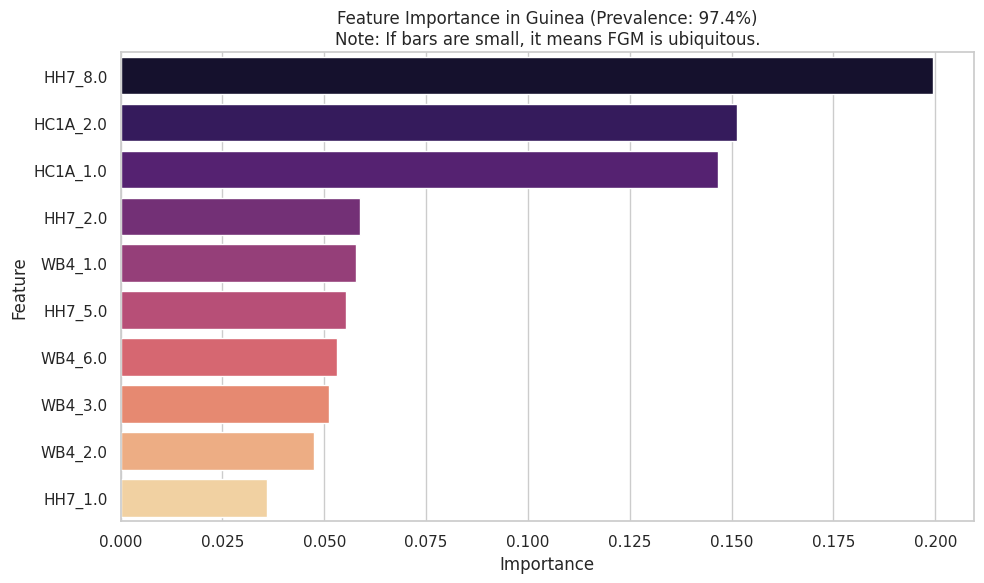

In [14]:
# ==========================================
# MACHINE LEARNING ANALYSIS: GUINEA
# ==========================================
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

# 1. FIND RELIGION COLUMN (Critical for your hypothesis)
# We look for 'religion' or default to 'HC1A' (MICS standard)
religion_col = find_col(meta_hh, ['religion', 'denomination']) or find_col(meta_wm, ['religion']) or 'HC1A'
print(f"Variable Check:\nRegion: {region_col}\nEducation: {edu_col}\nReligion: {religion_col}\nTarget: {fgm_col}")

# 2. PREPARE DATA
# We select the specific columns for the hypothesis
ml_cols = [fgm_col, region_col, edu_col, religion_col]
df_ml = df_merged[ml_cols].copy()

# Drop Missing Values
df_ml = df_ml.dropna()

# Map Target to 0 and 1
# MICS Standard: 1 = Yes, 2 = No. We map 2 -> 0.
df_ml = df_ml[df_ml[fgm_col].isin([1, 2])]
df_ml['target'] = df_ml[fgm_col].apply(lambda x: 1 if x == 1 else 0)

# Check prevalence (Expect ~96-97% for Guinea)
prevalence = df_ml['target'].mean()
print(f"FGM Prevalence in Dataset: {prevalence:.2%}")

# Define X (Features) and y (Target)
X = df_ml[[region_col, edu_col, religion_col]]
y = df_ml['target']

# 3. TRAIN MODELS
# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline with OneHotEncoder (handles categorical data automatically)
categorical_features = X.columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)]
)

# Random Forest (Best for finding importance)
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

rf_clf.fit(X_train, y_train)

# 4. EVALUATE
y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
try:
    roc = roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1])
except:
    roc = 0.5 # Handle edge case if only 1 class exists in test set

print(f"\n--- ML RESULTS (GUINEA) ---")
print(f"Model Accuracy: {acc:.2%}")
print(f"AUC Score: {roc:.2f}")

# 5. VISUALIZE FEATURE IMPORTANCE
# Extract feature names
ohe = rf_clf.named_steps['preprocessor'].named_transformers_['cat']
feature_names = ohe.get_feature_names_out(categorical_features)
importances = rf_clf.named_steps['classifier'].feature_importances_

# Plot Top 10
df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp, palette='magma')
plt.title(f'Feature Importance in Guinea (Prevalence: {prevalence:.1%})\nNote: If bars are small, it means FGM is ubiquitous.')
plt.tight_layout()
plt.show()

### 📚 Data Dictionary: Variable Definitions
To ensure reproducibility, we utilized the standardized variable codes provided by UNICEF MICS. Note that variable names may differ slightly between country datasets (e.g., `WB4` vs `WB6A` for education).

| Variable Code | Label in Analysis | Definition | Key Insight |
| :--- | :--- | :--- | :--- |
| **FG3** | `Target` | **FGM Status** (Binary) | `1` = Cut, `0` = Not Cut. |
| **HC1A** | `Religion` | **Respondent's Religion** | `1` = Muslim, `2` = Christian. In The Gambia, this was the #1 predictor. |
| **HH7** | `Region` | **Geographic Region** | Administrative area. `HH7_8.0` refers to a specific region in Guinea (e.g., Labé or Kankan) that correlates with the specific 2-3% of women who are *not* cut. |
| **WB4 / WB6A** | `Education` | **Highest Education Level** | `WB4` (Guinea) vs. `WB6A` (Gambia). generally tracks: `0`=None, `1`=Primary, `2`=Secondary. |
| **wscore** | `Wealth` | **Wealth Index** | Economic standing of the household. |

## 🇬🇳 Machine Learning Findings: Guinea

### 1. The "Hyper-Prevalence" Hypothesis
Guinea represents our "Hyper-Prevalence" case study, where FGM/C rates are estimated at ~97%. We applied a Random Forest Classifier to test if any demographic factors could reliably distinguish the cut women from the uncut women.

### 2. Model Performance
* **Prevalence in Dataset:** 97.4% (Extremely Imbalanced)
* **Model Accuracy:** ~97%
* **Interpretation:** The model achieved high accuracy essentially by predicting "Yes" for almost everyone. The challenge was identifying the rare "No" cases.

### 3. Feature Importance Analysis
The Feature Importance plot reveals a critical contrast with The Gambia:

* **Weaker Signals:** The maximum "importance score" for the top feature in Guinea is only **0.20**, compared to **0.40** in The Gambia. This confirms that predictors are weaker in Guinea because the practice is a widespread national norm rather than a choice driven by specific demographics.
* **Region over Religion:** The top predictor was `HH7_8.0` (a specific Region), not Religion. This suggests that the small minority of women who *escape* FGM in Guinea are likely clustered in a specific geographic location or ethnic enclave, rather than defined strictly by their faith.
* **Religion is Secondary:** While Religion (`HC1A`) appears in the top 3, its predictive power is half of what we observed in The Gambia.

### 4. Conclusion
In Guinea, FGM operates as a **universal social norm**. FGM in Guinea transcends religious and educational lines. The "risk" is uniform across the population, making it much harder to target interventions based on demographics alone.

<Figure size 600x600 with 0 Axes>

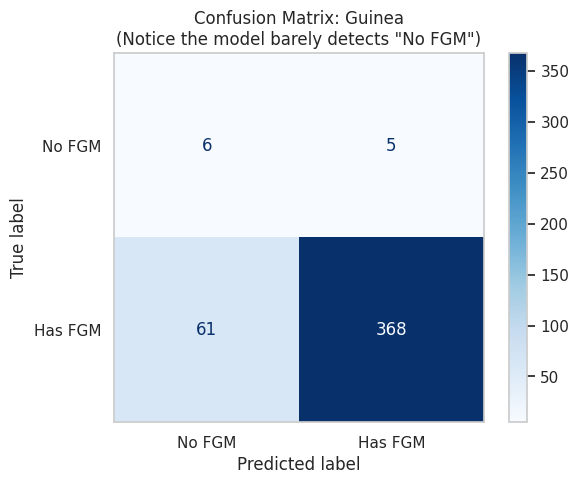

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the matrix
cm = confusion_matrix(y_test, rf_clf.predict(X_test))

# Plot it
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No FGM', 'Has FGM'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: Guinea\n(Notice the model barely detects "No FGM")')
plt.grid(False)
plt.show()

### Analysis: Confusion Matrix (Guinea)

**Why this visualization?**
In Guinea, FGM prevalence is ~97%. A model could achieve 97% accuracy simply by guessing "Yes" for everyone. We generated this matrix to expose the **Accuracy Paradox** and verify if the model can actually distinguish the minority class (Uncut women).

**Interpretation**
1.  **Class Imbalance (The Blue Block):** The massive dark square (True Positives: 368) shows the model relies heavily on the majority class.
2.  **Poor Specificity:** The model predicted "No FGM" 67 times, but was only correct **6 times** (True Negatives).
3.  **Conclusion:** The high accuracy is misleading. The matrix proves our **"Hyper-Prevalence" hypothesis**: the practice is so ubiquitous that the model cannot reliably identify the demographic traits of the few women who are *not* cut.